In [1]:
from distance.EuclideanDistance import EuclideanDistance
from utilities.visualization import Visualizer
from utilities.dataset_factory import DatasetFactory
import numpy as np
import keras
from CL_utilities import loss_function

# Hyperparameters

In [2]:
image_size = (258, 320)
epochs = 10
batch_size = 16
margin = 0.5
training_pairs = 280
validation_pairs = 40
training_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Training"
validation_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Validation"

# Building training dataset 
# (1.) See Documentation to get info about structure of dataset

In [3]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(training_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(258, 320, 3)


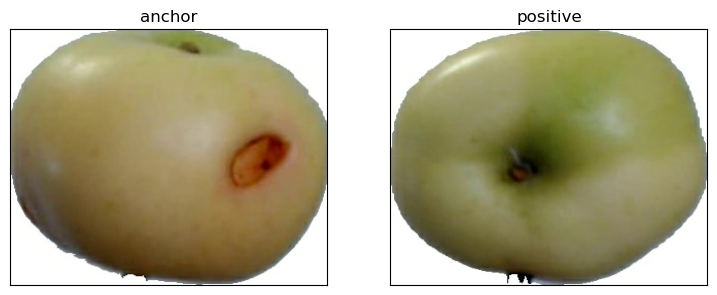

In [8]:
image, _ = next(iter(training_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

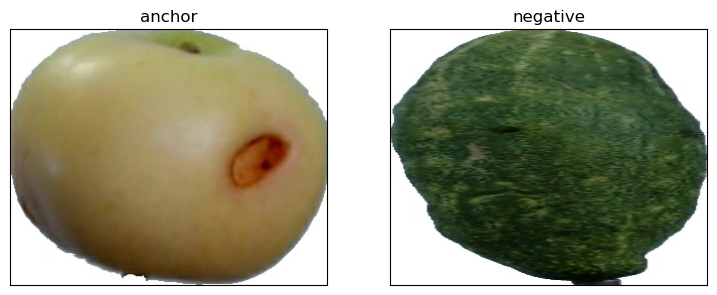

In [9]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

# Creating validation dataset

In [10]:
validation_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(validation_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(258, 320, 3)


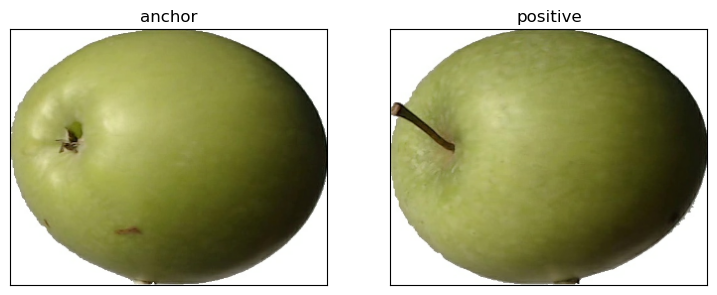

In [11]:
image, _ = next(iter(validation_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

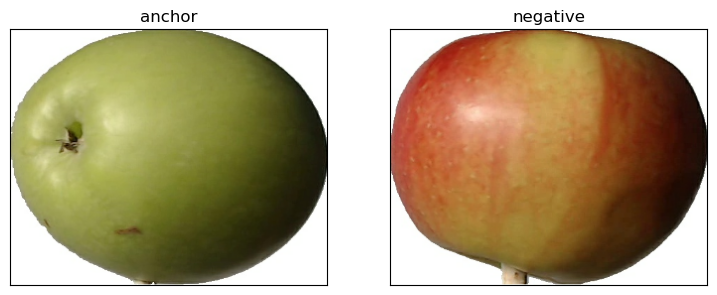

In [12]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

In [13]:
input_layer = keras.layers.Input((258,320,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
embedding_network = keras.Model(input_layer, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu


In [14]:
input_1 = keras.layers.Input(image_size + (3,))
input_2 = keras.layers.Input(image_size + (3,))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

# euclidean_distance = 
merge_layer = keras.layers.Lambda(EuclideanDistance(), output_shape=(1,))([tower_1, tower_2])

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [15]:
siamese.compile(loss=loss_function.loss(margin=margin), optimizer='adam', metrics=['accuracy'])
siamese.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 16)        │ 19,830,556 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,830,562 (75.65 MB)

 Trainable params: 19,830,426 (75.65 MB)

 Non-trainable params: 136 (544.00 B)

In [16]:
# How many samples we have, and how many we want in train and validation
# num_samples = sum(1 for _ in touple_of_products)
# train_size = int(0.8 * num_samples)
# val_size = num_samples - train_size
# # .take() to get from actual batch
# train_dataset = touple_of_products.take(train_size)
# val_dataset = touple_of_products.skip(train_size)

Trained_model_data = siamese.fit(training_dataset, 
                                 validation_data= validation_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs
                                )

Epoch 1/10
     35/Unknown 81s 2s/step - accuracy: 0.2365 - loss: 0.1496

C:\Users\matim\Apps\Anaconda3\envs\ml\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.2384 - loss: 0.1493 - val_accuracy: 0.4643 - val_loss: 0.1099
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.4022 - loss: 0.1280 - val_accuracy: 0.4446 - val_loss: 0.1095
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.4034 - loss: 0.1201 - val_accuracy: 0.4286 - val_loss: 0.1114
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4801 - loss: 0.1159 - val_accuracy: 0.4946 - val_loss: 0.1045
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.4931 - loss: 0.1100 - val_accuracy: 0.5000 - val_loss: 0.1022
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5000 - loss: 0.1055 - val_accuracy: 0.5000 - val_loss: 0.0992
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.4990 - loss: 0.1018 - val_accuracy: 0.5000 - val_loss: 0.0969
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5000 - loss: 0.0963 - val_accuracy: 0.5000 - val_loss: 0.0952
Epo